<a href="https://colab.research.google.com/github/DanialBahrami/power_demand_prediction/blob/main/power_demand_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Electricity Demand Prediction for the next day (next 24 hours).**

*Objective:*

>  We need to predict the demand for the next 24 hours by utilizing past electricity demand data points, humidity, temperature, dew point, and other drivers like weekdays, holidays, and etc. The accuracy of this model is so critical (Accuracy > 0.95 for a sample day is acceptable, or AE < 700 in july or august months)

Inputs: 

- Excel file containing all drivers


Data Considerations: 

- The data set may contain outliers and abnormal values.

Output: 

- A 24-hour demand forecast for a sample day

Success Criteria: 

- The acceptable error rate must be less than 5% (MAE < 500 MW, or accuracy more than 95%)

Deliverables: 

- A clean and understandable Jupyter file with well-documented code
- An explanation of the work process in a meeting (no file submission required)

Deadline: 

- five days after the task description has been sent

Evaluation:

- The work will be evaluated based on the accuracy of the electricity demand forecast, the clarity of the code and documentation, and the overall effectiveness of the solution.




In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# google drive conncection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read data 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CamrosTech/Dataset.csv',
					index_col ='Date',
					parse_dates = True)

# Print the first five rows of the dataset
df.head()
df_orginal = df.copy()
df_orginal

Weekday  Hour   HOEP  Power_Demand  Temperature  Windchill_Index  \
Date                                                                            
2016-01-01    Friday     0   0.49         14023         -0.3            -5.62   
2016-01-01    Friday     1  -1.09         13417         -0.3            -6.30   
2016-01-01    Friday     2  -2.41         12968         -0.4            -6.55   
2016-01-01    Friday    12   0.00         14215         -2.1            -8.72   
2016-01-01    Friday    13   0.00         14443         -2.4            -8.23   
...              ...   ...    ...           ...          ...              ...   
2020-12-31  Thursday    19  36.85         17384          0.2            -4.02   
2020-12-31  Thursday    20  19.69         16783         -0.2            -5.59   
2020-12-31  Thursday    21  20.78         16154         -3.0            -7.44   
2020-12-31  Thursday    22  27.85         15744         -0.8            -6.76   
2020-12-31  Thursday    23  19.68         15092         -2.1            -6.21   

            Wind_Speed  Humidex  Relative_Humidity  Dew_Point  \
Date                                                            
2016-01-01          20    -3.18                 70       -5.1   
2016-01-01          25    -3.48                 68       -5.5   
2016-01-01          26    -3.43                 73       -4.7   
2016-01-01          23    -4.86                 76       -5.8   
2016-01-01          19    -5.09                 84       -4.7   
...                ...      ...                ...        ...   
2020-12-31          13    -2.69                 74       -3.8   
2020-12-31          16    -3.58                 65       -6.0   
2020-12-31          12    -3.67                 80       -6.0   
2020-12-31          17    -4.11                 70       -5.6   
2020-12-31          11    -4.72                 73       -6.2   

            Pressure_Station  
Date                          
2016-01-01             99.67  
2016-01-01             99.63  
2016-01-01             99.59  
2016-01-01             99.39  
2016-01-01             99.35  
...                      ...  
2020-12-31            100.66  
2020-12-31            100.76  
2020-12-31            100.81  
2020-12-31            100.90  
2020-12-31            100.90  

[39408 rows x 11 columns]

**EDA and Data Profiling**

In [ ]:
df.reset_index(inplace=True)
df

Date   Weekday  Hour   HOEP  Power_Demand  Temperature  \
0     2016-01-01    Friday     0   0.49         14023         -0.3   
1     2016-01-01    Friday     1  -1.09         13417         -0.3   
2     2016-01-01    Friday     2  -2.41         12968         -0.4   
3     2016-01-01    Friday    12   0.00         14215         -2.1   
4     2016-01-01    Friday    13   0.00         14443         -2.4   
...          ...       ...   ...    ...           ...          ...   
39403 2020-12-31  Thursday    19  36.85         17384          0.2   
39404 2020-12-31  Thursday    20  19.69         16783         -0.2   
39405 2020-12-31  Thursday    21  20.78         16154         -3.0   
39406 2020-12-31  Thursday    22  27.85         15744         -0.8   
39407 2020-12-31  Thursday    23  19.68         15092         -2.1   

       Windchill_Index  Wind_Speed  Humidex  Relative_Humidity  Dew_Point  \
0                -5.62          20    -3.18                 70       -5.1   
1                -6.30          25    -3.48                 68       -5.5   
2                -6.55          26    -3.43                 73       -4.7   
3                -8.72          23    -4.86                 76       -5.8   
4                -8.23          19    -5.09                 84       -4.7   
...                ...         ...      ...                ...        ...   
39403            -4.02          13    -2.69                 74       -3.8   
39404            -5.59          16    -3.58                 65       -6.0   
39405            -7.44          12    -3.67                 80       -6.0   
39406            -6.76          17    -4.11                 70       -5.6   
39407            -6.21          11    -4.72                 73       -6.2   

       Pressure_Station  
0                 99.67  
1                 99.63  
2                 99.59  
3                 99.39  
4                 99.35  
...                 ...  
39403            100.66  
39404            100.76  
39405            100.81  
39406            100.90  
39407            100.90  

[39408 rows x 12 columns]

I've used ydata (pandas profiling) for feature analysis. link to the library: https://github.com/ydataai/ydata-profiling

In [ ]:
# using ydata (panda profiling) for feature analysis
!pip install ydata-profiling
IPython.display.clear_output()

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, tsmode=True, sortby="Date", title="Profiling Report")
profile

Generally, we can classify time series forecasting problems into two categories:

1. Univariate: Involving a single time-dependent variable.
2. Multivariate: Involving more than one time-dependent variable.

In this particular case, the problem at hand is a multivariate time series prediction. I will explore various methods ranging from simple to advanced and assess their performance.

Here are the different approaches I will consider:

- Classical/Statistical Models: Moving Averages, Exponential Smoothing, ARIMA, SARIMA, and TBATS.
- Machine Learning: Linear Regression, XGBoost, Random Forest.
- Deep Learning: RNN, LSTM.


**Reggression Model**

In regression methods, time series data can be viewed as observations and labels, making it suitable for fitting regression models. To simplify the process, I utilized Pycaret, a framework known for its user-friendly interface and ease of use. https://github.com/pycaret/pycaret

In [ ]:
# using Pycaret library for regression 
!pip install --upgrade pycaret
IPython.display.clear_output()

In [ ]:
from pycaret.regression import *

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df = df.drop(columns=['Date'])

KeyError: ignored

In [ ]:
# split dataset to train and test
n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

In [ ]:
# initialize setup
s = setup(data = train_df, test_data = test_df, target = 'Power_Demand', fold_strategy = 'timeseries'
, numeric_features = ['Year', 'Month','Day','Hour','HOEP','Temperature','Windchill_Index','Wind_Speed','Humidex','Relative_Humidity','Dew_Point', 'Pressure_Station']
,categorical_features=['Weekday'] , fold = 3, transform_target = True,normalize = True, transformation = True, session_id = 123)

In [ ]:
best = compare_models(sort = 'MAE')

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# best = lightgbm
predictions_test = predict_model(best, data=test_df)

NameError: ignored

In [ ]:
predictions_test

Weekday  Hour       HOEP  Temperature  Windchill_Index  Wind_Speed  \
31526  Thursday    21  22.520000         -2.6            -8.52          20   
31527  Thursday    22  21.370001         -2.6            -8.68          21   
31528  Thursday    23  19.160000         -2.9            -9.21          22   
31529    Friday     0  14.980000         -3.0            -5.89           7   
31530    Friday     1  16.730000         -3.0            -8.51          17   
...         ...   ...        ...          ...              ...         ...   
39403  Thursday    19  36.849998          0.2            -4.02          13   
39404  Thursday    20  19.690001         -0.2            -5.59          16   
39405  Thursday    21  20.780001         -3.0            -7.44          12   
39406  Thursday    22  27.850000         -0.8            -6.76          17   
39407  Thursday    23  19.680000         -2.1            -6.21          11   

       Humidex  Relative_Humidity  Dew_Point  Pressure_Station  Year  Month  \
31526    -5.71                 79       -5.7        100.370003  2020      1   
31527    -5.79                 76       -6.2        100.349998  2020      1   
31528    -6.08                 74       -6.8        100.330002  2020      1   
31529    -6.40                 75       -6.8        100.339996  2020      1   
31530    -6.37                 76       -6.6        100.330002  2020      1   
...        ...                ...        ...               ...   ...    ...   
39403    -2.69                 74       -3.8        100.660004  2020     12   
39404    -3.58                 65       -6.0        100.760002  2020     12   
39405    -3.67                 80       -6.0        100.809998  2020     12   
39406    -4.11                 70       -5.6        100.900002  2020     12   
39407    -4.72                 73       -6.2        100.900002  2020     12   

       Day  Power_Demand  prediction_label  
31526   30     19.118855      18891.200259  
31527   30     18.998053      18158.679368  
31528   30     18.809331      17189.881694  
31529   31     18.496166      15912.968699  
31530   31     18.452489      15067.371152  
...    ...           ...               ...  
39403   31     18.883429      17927.027345  
39404   31     18.766806      17367.424654  
39405   31     18.640758      17639.032529  
39406   31     18.556260      16936.981298  
39407   31     18.417825      16061.236717  

[7882 rows x 15 columns]

In [ ]:
tuned_best = tune_model(best, optimize = 'MSE')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# ax = predictions_test['Power_Demand'].plot.line(figsize=(15, 5))
# predictions_test['prediction_label'].div(1000).plot.line(ax=ax)
# plt.legend(['Truth Data', 'Predictions'])
# ax.set_title('Raw Data and Prediction')
# plt.show()

**RNN Based - LSTM**

Now we will use RNN model for timeseries predicition. 


**Single Shot LSTM Model**

Make the predictions all at once.

In [ ]:
# create datetime onject based on date and hour
def combine_date_hour(row):
  return row['Date'] + pd.Timedelta(row['Hour'],'h') 

In [ ]:
df_orginal

Weekday  Hour   HOEP  Power_Demand  Temperature  Windchill_Index  \
Date                                                                            
2016-01-01    Friday     0   0.49         14023         -0.3            -5.62   
2016-01-01    Friday     1  -1.09         13417         -0.3            -6.30   
2016-01-01    Friday     2  -2.41         12968         -0.4            -6.55   
2016-01-01    Friday    12   0.00         14215         -2.1            -8.72   
2016-01-01    Friday    13   0.00         14443         -2.4            -8.23   
...              ...   ...    ...           ...          ...              ...   
2020-12-31  Thursday    19  36.85         17384          0.2            -4.02   
2020-12-31  Thursday    20  19.69         16783         -0.2            -5.59   
2020-12-31  Thursday    21  20.78         16154         -3.0            -7.44   
2020-12-31  Thursday    22  27.85         15744         -0.8            -6.76   
2020-12-31  Thursday    23  19.68         15092         -2.1            -6.21   

            Wind_Speed  Humidex  Relative_Humidity  Dew_Point  \
Date                                                            
2016-01-01          20    -3.18                 70       -5.1   
2016-01-01          25    -3.48                 68       -5.5   
2016-01-01          26    -3.43                 73       -4.7   
2016-01-01          23    -4.86                 76       -5.8   
2016-01-01          19    -5.09                 84       -4.7   
...                ...      ...                ...        ...   
2020-12-31          13    -2.69                 74       -3.8   
2020-12-31          16    -3.58                 65       -6.0   
2020-12-31          12    -3.67                 80       -6.0   
2020-12-31          17    -4.11                 70       -5.6   
2020-12-31          11    -4.72                 73       -6.2   

            Pressure_Station  
Date                          
2016-01-01             99.67  
2016-01-01             99.63  
2016-01-01             99.59  
2016-01-01             99.39  
2016-01-01             99.35  
...                      ...  
2020-12-31            100.66  
2020-12-31            100.76  
2020-12-31            100.81  
2020-12-31            100.90  
2020-12-31            100.90  

[39408 rows x 11 columns]

In [ ]:
df = df_orginal
df.reset_index(inplace=True)
df['Date_Time']= df.apply(combine_date_hour,axis=1)
df.head()

Date Weekday  Hour  HOEP  Power_Demand  Temperature  Windchill_Index  \
0 2016-01-01  Friday     0  0.49         14023         -0.3            -5.62   
1 2016-01-01  Friday     1 -1.09         13417         -0.3            -6.30   
2 2016-01-01  Friday     2 -2.41         12968         -0.4            -6.55   
3 2016-01-01  Friday    12  0.00         14215         -2.1            -8.72   
4 2016-01-01  Friday    13  0.00         14443         -2.4            -8.23   

   Wind_Speed  Humidex  Relative_Humidity  Dew_Point  Pressure_Station  \
0          20    -3.18                 70       -5.1             99.67   
1          25    -3.48                 68       -5.5             99.63   
2          26    -3.43                 73       -4.7             99.59   
3          23    -4.86                 76       -5.8             99.39   
4          19    -5.09                 84       -4.7             99.35   

            Date_Time  
0 2016-01-01 00:00:00  
1 2016-01-01 01:00:00  
2 2016-01-01 02:00:00  
3 2016-01-01 12:00:00  
4 2016-01-01 13:00:00

In [ ]:
df.columns

Index(['Date', 'Weekday', 'Hour', 'HOEP', 'Power_Demand', 'Temperature',
       'Windchill_Index', 'Wind_Speed', 'Humidex', 'Relative_Humidity',
       'Dew_Point', 'Pressure_Station', 'Date_Time'],
      dtype='object')

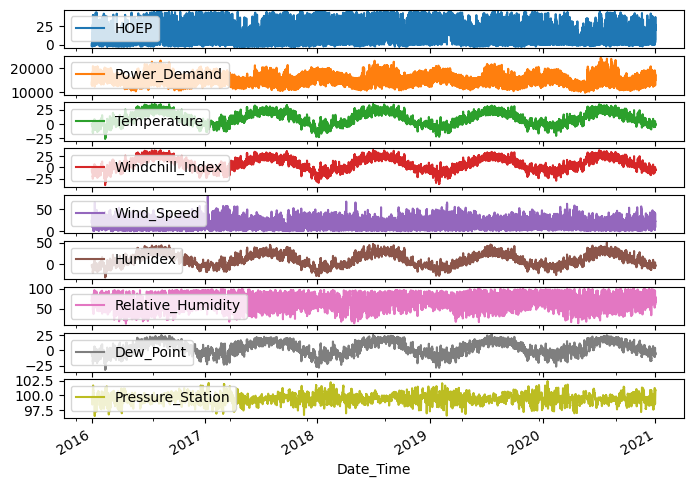

In [ ]:
plot_cols = ['HOEP', 'Power_Demand', 'Temperature','Windchill_Index', 
             'Wind_Speed', 'Humidex', 'Relative_Humidity',
              'Dew_Point', 'Pressure_Station']

plot_features = df[plot_cols]
plot_features.index = df['Date_Time']
_ = plot_features.plot(subplots=True)


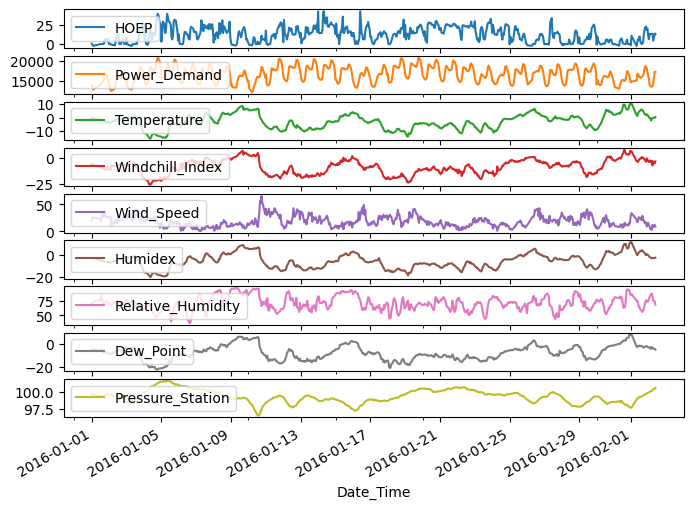

In [ ]:
plot_features = df[plot_cols][:720]
plot_features.index = df['Date_Time'][:720]
_ = plot_features.plot(subplots=True)

<ipython-input-10-609ce31a8c74>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.set_index('Date_Time', inplace=False).drop(columns=['Hour']).resample('M').mean().plot(subplots=True)


array([<Axes: xlabel='Date_Time'>, <Axes: xlabel='Date_Time'>,
       <Axes: xlabel='Date_Time'>, <Axes: xlabel='Date_Time'>,
       <Axes: xlabel='Date_Time'>, <Axes: xlabel='Date_Time'>,
       <Axes: xlabel='Date_Time'>, <Axes: xlabel='Date_Time'>,
       <Axes: xlabel='Date_Time'>], dtype=object)

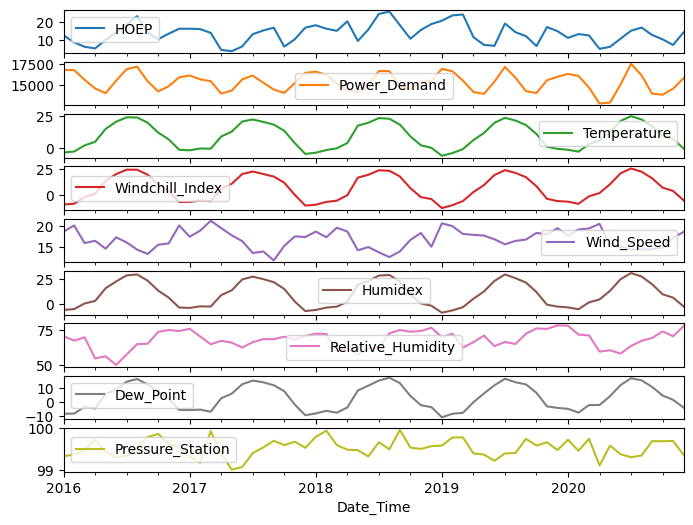

In [ ]:
df.set_index('Date_Time', inplace=False).drop(columns=['Hour']).resample('M').mean().plot(subplots=True)

In [ ]:
df.describe().transpose()

count          mean          std      min       25%  \
Hour               39408.0     11.625076     6.945136     0.00      6.00   
HOEP               39408.0     13.923340    11.902378    -2.77      3.30   
Power_Demand       39408.0  15397.914205  2201.241563  9831.00  13775.00   
Temperature        39408.0      9.421272    10.899602   -26.00      0.80   
Windchill_Index    39408.0      6.565978    13.513148   -39.66     -3.95   
Wind_Speed         39408.0     16.854243     9.220125     0.00     10.00   
Humidex            39408.0      9.859521    14.325742   -31.10     -1.68   
Relative_Humidity  39408.0     68.028598    16.773789    13.00     57.00   
Dew_Point          39408.0      3.330397    10.269080   -31.60     -4.40   
Pressure_Station   39408.0     99.533605     0.776696    96.49     99.05   

                        50%       75%       max  
Hour                  12.00     18.00     23.00  
HOEP                  12.95     22.51     44.11  
Power_Demand       15272.00  16881.00  24281.00  
Temperature            8.60     19.00     35.10  
Windchill_Index        5.67     18.58     37.94  
Wind_Speed            16.00     22.00     80.00  
Humidex                7.86     22.35     50.35  
Relative_Humidity     69.00     81.00    100.00  
Dew_Point              3.00     12.10     25.10  
Pressure_Station      99.54    100.04    102.41

In [ ]:
df.isnull().sum()

Date                 0
Weekday              0
Hour                 0
HOEP                 0
Power_Demand         0
Temperature          0
Windchill_Index      0
Wind_Speed           0
Humidex              0
Relative_Humidity    0
Dew_Point            0
Pressure_Station     0
Date_Time            0
dtype: int64

In [ ]:
# remove duplicate indexes
df.drop_duplicates(subset=['Date_Time'], inplace=True)

In [ ]:
# complete the time series, fill the missing datapoints with the nearest available point 
start_date = df['Date_Time'].min()
end_date = df['Date_Time'].max()

df_c = df.set_index(['Date_Time'])
df_c = df_c.reindex(pd.date_range(start_date, end_date, freq='H'), method='nearest')

In [ ]:
df_c.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', length=43848, freq='H')

Text(0.5, 1.0, 'Time of day signal')

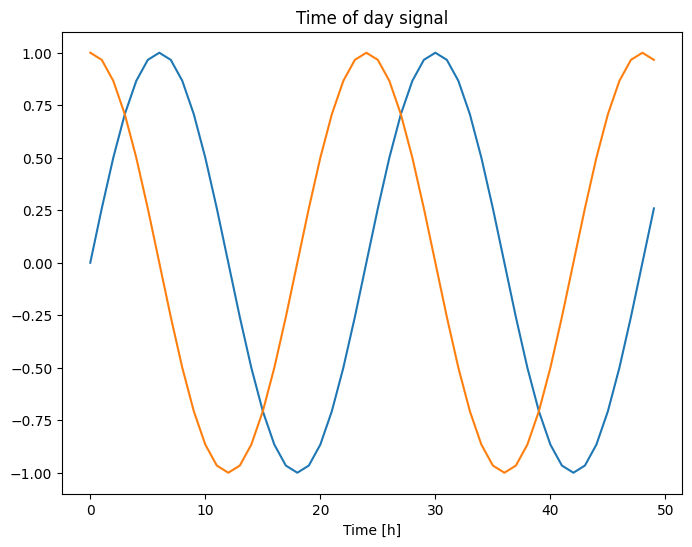

In [ ]:
# demand data has clear daily and yearly periodicity
# get signals by using sine and cosine transforms of time to create "Time of day" and "Time of year" signals
date_time = df_c.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df_c['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_c['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_c['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_c['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df_c['Day sin'])[:50])
plt.plot(np.array(df_c['Day cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
# handeling categorical variables
days = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_c['Weekday'] = df_c['Weekday'].map(days)

In [ ]:
df_c.drop(columns=['Date', 'Hour'], inplace=True)
column_indices = {name: i for i, name in enumerate(df_c.columns)}
num_features = df_c.shape[1]

In [ ]:
# use a (70%, 20%, 10%) split for the training, validation, and test sets.
n = len(df_c)
train_df = df_c[0:int(n*0.7)]
val_df = df_c[int(n*0.7):int(n*0.9)]
test_df = df_c[int(n*0.9):]

In [ ]:
df_c

Weekday   HOEP  Power_Demand  Temperature  \
2016-01-01 00:00:00        4   0.49         14023         -0.3   
2016-01-01 01:00:00        4  -1.09         13417         -0.3   
2016-01-01 02:00:00        4  -2.41         12968         -0.4   
2016-01-01 03:00:00        4  -2.41         12968         -0.4   
2016-01-01 04:00:00        4  -2.41         12968         -0.4   
...                      ...    ...           ...          ...   
2020-12-31 19:00:00        3  36.85         17384          0.2   
2020-12-31 20:00:00        3  19.69         16783         -0.2   
2020-12-31 21:00:00        3  20.78         16154         -3.0   
2020-12-31 22:00:00        3  27.85         15744         -0.8   
2020-12-31 23:00:00        3  19.68         15092         -2.1   

                     Windchill_Index  Wind_Speed  Humidex  Relative_Humidity  \
2016-01-01 00:00:00            -5.62          20    -3.18                 70   
2016-01-01 01:00:00            -6.30          25    -3.48                 68   
2016-01-01 02:00:00            -6.55          26    -3.43                 73   
2016-01-01 03:00:00            -6.55          26    -3.43                 73   
2016-01-01 04:00:00            -6.55          26    -3.43                 73   
...                              ...         ...      ...                ...   
2020-12-31 19:00:00            -4.02          13    -2.69                 74   
2020-12-31 20:00:00            -5.59          16    -3.58                 65   
2020-12-31 21:00:00            -7.44          12    -3.67                 80   
2020-12-31 22:00:00            -6.76          17    -4.11                 70   
2020-12-31 23:00:00            -6.21          11    -4.72                 73   

                     Dew_Point  Pressure_Station       Day sin   Day cos  \
2016-01-01 00:00:00       -5.1             99.67 -1.407890e-12  1.000000   
2016-01-01 01:00:00       -5.5             99.63  2.588190e-01  0.965926   
2016-01-01 02:00:00       -4.7             99.59  5.000000e-01  0.866025   
2016-01-01 03:00:00       -4.7             99.59  7.071068e-01  0.707107   
2016-01-01 04:00:00       -4.7             99.59  8.660254e-01  0.500000   
...                        ...               ...           ...       ...   
2020-12-31 19:00:00       -3.8            100.66 -9.659258e-01  0.258819   
2020-12-31 20:00:00       -6.0            100.76 -8.660254e-01  0.500000   
2020-12-31 21:00:00       -6.0            100.81 -7.071068e-01  0.707107   
2020-12-31 22:00:00       -5.6            100.90 -5.000000e-01  0.866025   
2020-12-31 23:00:00       -6.2            100.90 -2.588190e-01  0.965926   

                     Year sin  Year cos  
2016-01-01 00:00:00 -0.002666  0.999996  
2016-01-01 01:00:00 -0.001950  0.999998  
2016-01-01 02:00:00 -0.001233  0.999999  
2016-01-01 03:00:00 -0.000516  1.000000  
2016-01-01 04:00:00  0.000201  1.000000  
...                       ...       ...  
2020-12-31 19:00:00  0.007297  0.999973  
2020-12-31 20:00:00  0.008014  0.999968  
2020-12-31 21:00:00  0.008730  0.999962  
2020-12-31 22:00:00  0.009447  0.999955  
2020-12-31 23:00:00  0.010164  0.999948  

[43848 rows x 14 columns]

Single output LSTM

In [ ]:
df_input = df_c.reset_index(drop=True)

In [ ]:
df_input

Weekday   HOEP  Power_Demand  Temperature  Windchill_Index  Wind_Speed  \
0            4   0.49         14023         -0.3            -5.62          20   
1            4  -1.09         13417         -0.3            -6.30          25   
2            4  -2.41         12968         -0.4            -6.55          26   
3            4  -2.41         12968         -0.4            -6.55          26   
4            4  -2.41         12968         -0.4            -6.55          26   
...        ...    ...           ...          ...              ...         ...   
43843        3  36.85         17384          0.2            -4.02          13   
43844        3  19.69         16783         -0.2            -5.59          16   
43845        3  20.78         16154         -3.0            -7.44          12   
43846        3  27.85         15744         -0.8            -6.76          17   
43847        3  19.68         15092         -2.1            -6.21          11   

       Humidex  Relative_Humidity  Dew_Point  Pressure_Station       Day sin  \
0        -3.18                 70       -5.1             99.67 -1.407890e-12   
1        -3.48                 68       -5.5             99.63  2.588190e-01   
2        -3.43                 73       -4.7             99.59  5.000000e-01   
3        -3.43                 73       -4.7             99.59  7.071068e-01   
4        -3.43                 73       -4.7             99.59  8.660254e-01   
...        ...                ...        ...               ...           ...   
43843    -2.69                 74       -3.8            100.66 -9.659258e-01   
43844    -3.58                 65       -6.0            100.76 -8.660254e-01   
43845    -3.67                 80       -6.0            100.81 -7.071068e-01   
43846    -4.11                 70       -5.6            100.90 -5.000000e-01   
43847    -4.72                 73       -6.2            100.90 -2.588190e-01   

        Day cos  Year sin  Year cos  
0      1.000000 -0.002666  0.999996  
1      0.965926 -0.001950  0.999998  
2      0.866025 -0.001233  0.999999  
3      0.707107 -0.000516  1.000000  
4      0.500000  0.000201  1.000000  
...         ...       ...       ...  
43843  0.258819  0.007297  0.999973  
43844  0.500000  0.008014  0.999968  
43845  0.707107  0.008730  0.999962  
43846  0.866025  0.009447  0.999955  
43847  0.965926  0.010164  0.999948  

[43848 rows x 14 columns]

In [ ]:
#df_input.drop(columns=['ds'], inplace=True)
#df_input

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.66666667, 0.06953925, 0.29010381, ..., 1.        , 0.49866679,
        0.99999822],
       [0.66666667, 0.03583618, 0.24816609, ..., 0.98296291, 0.49902518,
        0.99999905],
       [0.66666667, 0.00767918, 0.21709343, ..., 0.9330127 , 0.49938357,
        0.99999962],
       ...,
       [0.5       , 0.50234642, 0.43757785, ..., 0.85355339, 0.50436515,
        0.99998095],
       [0.5       , 0.653157  , 0.40920415, ..., 0.9330127 , 0.50472353,
        0.99997769],
       [0.5       , 0.47888225, 0.36408304, ..., 0.98296291, 0.5050819 ,
        0.99997417]])

In [ ]:
features=data_scaled
target=data_scaled[:, 2]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=False)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
window_length = 72
batch_size = 32
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator[0]

(array([[[0.66666667, 0.06953925, 0.29010381, ..., 1.        ,
          0.49866679, 0.99999822],
         [0.66666667, 0.03583618, 0.24816609, ..., 0.98296291,
          0.49902518, 0.99999905],
         [0.66666667, 0.00767918, 0.21709343, ..., 0.9330127 ,
          0.49938357, 0.99999962],
         ...,
         [1.        , 0.54180887, 0.56574394, ..., 0.85355339,
          0.52338724, 0.99945274],
         [1.        , 0.62841297, 0.52013841, ..., 0.9330127 ,
          0.52374523, 0.99943585],
         [1.        , 0.37137372, 0.46885813, ..., 0.98296291,
          0.52410321, 0.9994187 ]],
 
        [[0.66666667, 0.03583618, 0.24816609, ..., 0.98296291,
          0.49902518, 0.99999905],
         [0.66666667, 0.00767918, 0.21709343, ..., 0.9330127 ,
          0.49938357, 0.99999962],
         [0.66666667, 0.00767918, 0.21709343, ..., 0.85355339,
          0.49974196, 0.99999993],
         ...,
         [1.        , 0.62841297, 0.52013841, ..., 0.9330127 ,
          0.52374523, 0.

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 128)           73216     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 72, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 72, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 72, 128)           0         
                                                                 
 dropout (Dropout)           (None, 72, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.MeanAbsolutePercentageError()])

history = model.fit_generator(train_generator, epochs=10,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/10


<ipython-input-23-f49d3c678385>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10,


1094/1094 [==============================] - 356s 314ms/step - loss: 0.0106 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 22.3208 - val_loss: 0.0150 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 22792.6113
Epoch 2/10
1094/1094 [==============================] - 365s 333ms/step - loss: 0.0052 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 15.9771 - val_loss: 0.0105 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error: 17244.5312
Epoch 3/10
1094/1094 [==============================] - 359s 328ms/step - loss: 0.0036 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 13.4248 - val_loss: 0.0071 - val_mean_absolute_error: 0.0666 - val_mean_absolute_percentage_error: 12726.8896
Epoch 4/10
1094/1094 [==============================] - 340s 310ms/step - loss: 0.0025 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 11.1568 - val_loss: 0.0060 - val_mean_absolute_error: 0.0602 - val_mean_absol

In [ ]:
predictions = model.predict(test_generator)

272/272 [==============================] - 42s 139ms/step


In [ ]:
predictions.shape

(8698, 1)

In [ ]:
y_test.shape

(8770,)

In [ ]:
x_test.shape

(8770, 14)

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[window_length:])], axis=1)

In [ ]:
df_pred.head()
print(df_pred[2].shape)
print(df_pred[0].shape)

(8698,)
(8698, 2)


In [ ]:
df_pred[0].head()

0         0
0  0.404725  0.833333
1  0.406282  0.833333
2  0.413150  0.833333
3  0.433860  0.833333
4  0.474015  0.833333

In [ ]:
df_pred.drop([2], inplace=True)
df_pred.head()

0         0         1         2         3         4       5   \
0  0.404725  0.833333  0.504693  0.435433  0.461538  0.461469  0.3125   
1  0.406282  0.833333  0.343430  0.432595  0.458265  0.471005  0.2625   
3  0.433860  0.833333  0.161476  0.471211  0.450082  0.459536  0.2875   
4  0.474015  0.833333  0.343857  0.515017  0.441899  0.463660  0.2250   
5  0.502976  0.833333  0.263865  0.488166  0.438625  0.454897  0.2500   

         6         7         8         9         10        11        12  \
0  0.375322  0.632184  0.504409  0.347973  0.250000  0.066987  0.529729   
1  0.379251  0.655172  0.506173  0.353041  0.146447  0.146447  0.530087   
3  0.364641  0.620690  0.486772  0.366554  0.017037  0.370590  0.530802   
4  0.367342  0.724138  0.507937  0.381757  0.000000  0.500000  0.531160   
5  0.360344  0.735632  0.506173  0.391892  0.017037  0.629410  0.531518   

         13  
0  0.999115  
1  0.999094  
3  0.999050  
4  0.999028  
5  0.999006

Multi Output LSTM

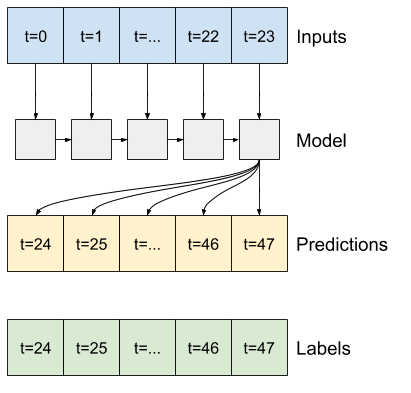

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Colab Notebooks/CamrosTech/multistep_lstm.png'))

In [ ]:
# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.head()

Weekday      HOEP  Power_Demand  Temperature  \
2016-01-01 00:00:00  0.499161 -1.048438     -0.665868    -0.822075   
2016-01-01 01:00:00  0.499161 -1.165250     -0.946238    -0.822075   
2016-01-01 02:00:00  0.499161 -1.262840     -1.153972    -0.831003   
2016-01-01 03:00:00  0.499161 -1.262840     -1.153972    -0.831003   
2016-01-01 04:00:00  0.499161 -1.262840     -1.153972    -0.831003   

                     Windchill_Index  Wind_Speed   Humidex  Relative_Humidity  \
2016-01-01 00:00:00        -0.833127    0.344657 -0.846949           0.163991   
2016-01-01 01:00:00        -0.882036    0.867499 -0.867528           0.044746   
2016-01-01 02:00:00        -0.900017    0.972067 -0.864098           0.342857   
2016-01-01 03:00:00        -0.900017    0.972067 -0.864098           0.342857   
2016-01-01 04:00:00        -0.900017    0.972067 -0.864098           0.342857   

                     Dew_Point  Pressure_Station   Day sin   Day cos  \
2016-01-01 00:00:00  -0.731526          0.167482 -0.000068  1.414339   
2016-01-01 01:00:00  -0.769187          0.116266  0.365944  1.366151   
2016-01-01 02:00:00  -0.693866          0.065051  0.707012  1.224869   
2016-01-01 03:00:00  -0.693866          0.065051  0.999894  1.000123   
2016-01-01 04:00:00  -0.693866          0.065051  1.224630  0.707228   

                     Year sin  Year cos  
2016-01-01 00:00:00 -0.133466  1.414088  
2016-01-01 01:00:00 -0.132444  1.414090  
2016-01-01 02:00:00 -0.131422  1.414092  
2016-01-01 03:00:00 -0.130399  1.414093  
2016-01-01 04:00:00 -0.129377  1.414093

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_df)
# train_scaled = scaler.transform(train_df)
# test_scaled = scaler.transform(test_df)
# scaled_val = scaler.transform(val_df)

# pd.DataFrame(train_scaled).head()

In [ ]:
train_df.head()

Weekday      HOEP  Power_Demand  Temperature  \
2016-01-01 00:00:00  0.499161 -1.048438     -0.665868    -0.822075   
2016-01-01 01:00:00  0.499161 -1.165250     -0.946238    -0.822075   
2016-01-01 02:00:00  0.499161 -1.262840     -1.153972    -0.831003   
2016-01-01 03:00:00  0.499161 -1.262840     -1.153972    -0.831003   
2016-01-01 04:00:00  0.499161 -1.262840     -1.153972    -0.831003   

                     Windchill_Index  Wind_Speed   Humidex  Relative_Humidity  \
2016-01-01 00:00:00        -0.833127    0.344657 -0.846949           0.163991   
2016-01-01 01:00:00        -0.882036    0.867499 -0.867528           0.044746   
2016-01-01 02:00:00        -0.900017    0.972067 -0.864098           0.342857   
2016-01-01 03:00:00        -0.900017    0.972067 -0.864098           0.342857   
2016-01-01 04:00:00        -0.900017    0.972067 -0.864098           0.342857   

                     Dew_Point  Pressure_Station   Day sin   Day cos  \
2016-01-01 00:00:00  -0.731526          0.167482 -0.000068  1.414339   
2016-01-01 01:00:00  -0.769187          0.116266  0.365944  1.366151   
2016-01-01 02:00:00  -0.693866          0.065051  0.707012  1.224869   
2016-01-01 03:00:00  -0.693866          0.065051  0.999894  1.000123   
2016-01-01 04:00:00  -0.693866          0.065051  1.224630  0.707228   

                     Year sin  Year cos  
2016-01-01 00:00:00 -0.133466  1.414088  
2016-01-01 01:00:00 -0.132444  1.414090  
2016-01-01 02:00:00 -0.131422  1.414092  
2016-01-01 03:00:00 -0.130399  1.414093  
2016-01-01 04:00:00 -0.129377  1.414093

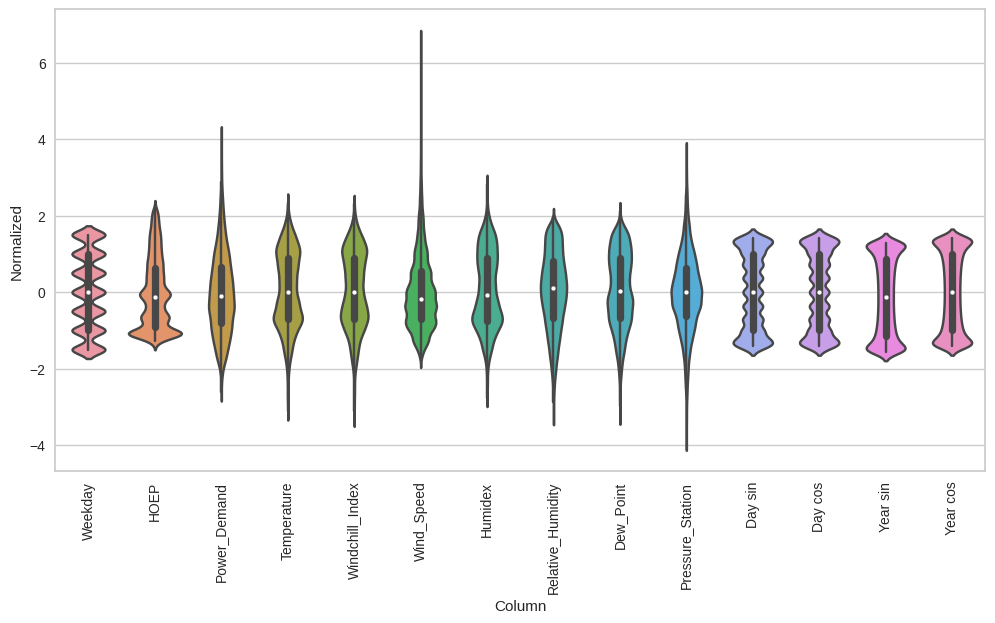

In [ ]:
# check features' distribution
df_std = (df_c - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_c.keys(), rotation=90)

In [ ]:
# data windowing - create dataset based on tensorflow dataset object, considering
# batch_size, length of timeseries and number of features

BATCH_SIZE = 16
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Power_Demand', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['Power_Demand']

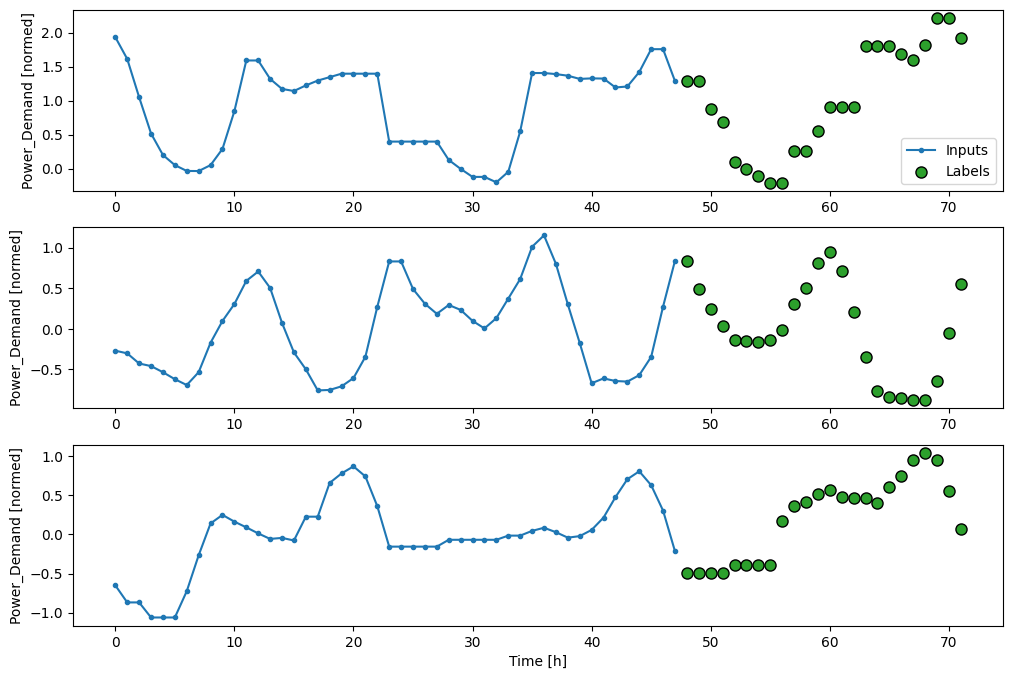

In [ ]:
# create window object for LSTM singleshot prediction 
OUT_STEPS = 24
dataset_ss = WindowGenerator(input_width=48,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Power_Demand'])

dataset_ss.plot()
dataset_ss

In [ ]:
# training function
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
# check inputs shapes

print('Train data ->', dataset_ss.train_df.shape)
# print('Number of batches -> ', len(list(dataset_ss.train)))
print('input shape to LSTM ->', next(iter(dataset_ss.train.take(1)))[0].shape)
print('Number of batches -> ', tf.data.experimental.cardinality(dataset_ss.train).numpy())

Train data -> (30693, 14)
input shape to LSTM -> (16, 48, 14)
Number of batches ->  1914


544/544 [==============================] - 4s 8ms/step - loss: 0.1065 - mean_absolute_error: 0.2462 - mean_absolute_percentage_error: 92.8446


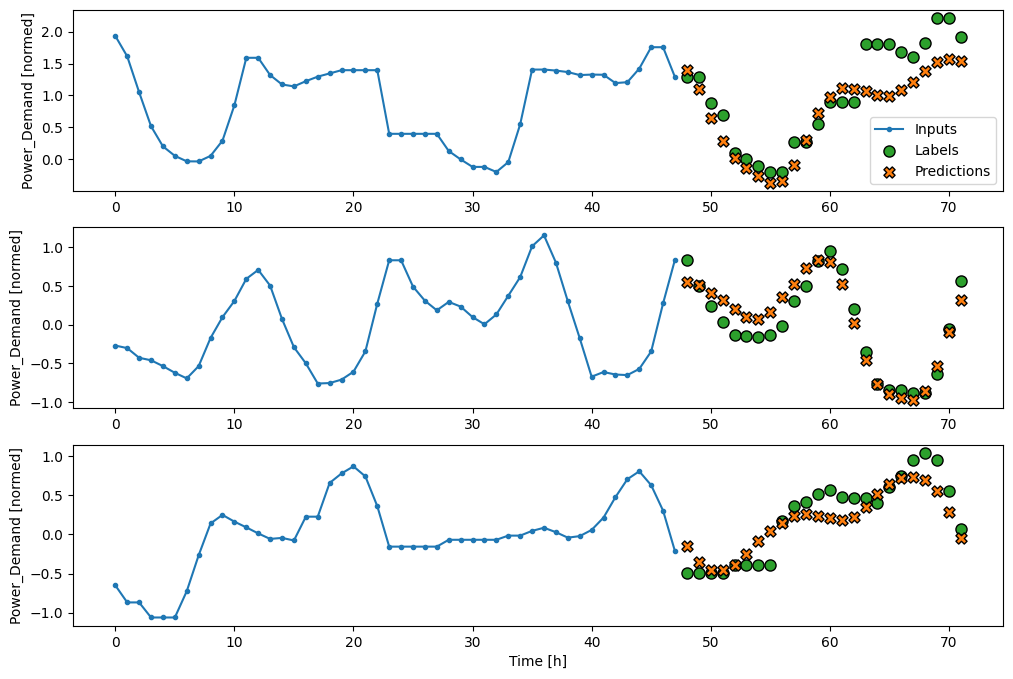

In [ ]:
# create LSTM model for singleshot(24 hours at on shot) prediction

lstm_singleshot = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

val_performance = {}
performance = {}

history = compile_and_fit(lstm_singleshot, dataset_ss)

IPython.display.clear_output()

val_performance['LSTM_singleshot'] = lstm_singleshot.evaluate(dataset_ss.val)
performance['LSTM_singleshot'] = lstm_singleshot.evaluate(dataset_ss.test, verbose=0)
dataset_ss.plot(lstm_singleshot)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from datetime import datetime
from datetime import timedelta
def predict_demand(datetime_str='2020-12-22 00:00:00', lookback=48):
  '''
    predict power demand for a sample date in the 'test dataset'
    lookback will configure the number of hours which model will look to generate the response
    - datetime_str in str %Y-%m-%d %H:%M:%S
    - lookback in hours
  '''
  date = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
  window = test_df.loc[date - timedelta(hours=lookback): date + timedelta(hours=24-1)]
  input = test_df.loc[date - timedelta(hours=lookback): date - timedelta(hours=1)]
  out = test_df.loc[date : date + timedelta(hours=23-1)]

  pred = lstm_singleshot.predict(np.array(input).reshape((1, lookback, 14)))
  pred_df = pd.DataFrame(pred.reshape((24,14)))

  y_prime = pred_df[pred_df.columns[2]]
  y_prime = pd.concat([input['Power_Demand'], y_prime], axis=0, ignore_index=True)

  y = window['Power_Demand']
  y.reset_index(drop=True)


  plt.plot(window.index, y_prime, label='Pred', marker='.', zorder=-10)
  plt.plot(window.index, y, label='True', marker='.',zorder=-10)
  plt.legend()
  plt.show()
  return mean_absolute_percentage_error(y.iloc[-lookback:], y_prime.iloc[-lookback:])

1/1 [==============================] - 0s 483ms/step


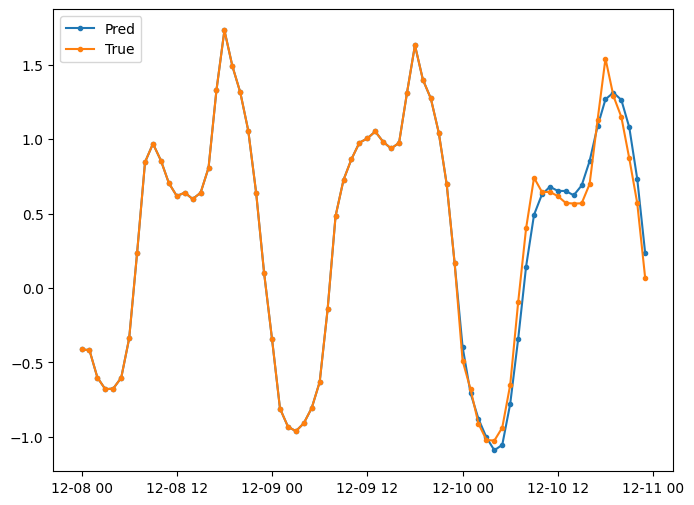

17.28623942860572

In [ ]:
predict_demand('2020-12-10 00:00:00')

In [ ]:
dataset_ss.test_df.shape

(4385, 14)

In [ ]:
res=lstm_singleshot.predict(dataset_ss.test)

270/270 [==============================] - 5s 12ms/step


In [ ]:
res.shape

(4314, 24, 14)

In [ ]:
#test_df.sort_index(inplace=True)
# sample_date = test_df.loc['2020-12-20 00:00:00': '2020-12-22 23:00:00']
# sample_in = sample_date.loc['2020-12-20 00:00:00': '2020-12-21 23:00:00']
# sample_out = sample_date.loc['2020-12-22 00:00:00': '2020-12-22 23:00:00']

**Autoregressive LSTM Model**

Make one prediction at a time and feed the output back to the model.


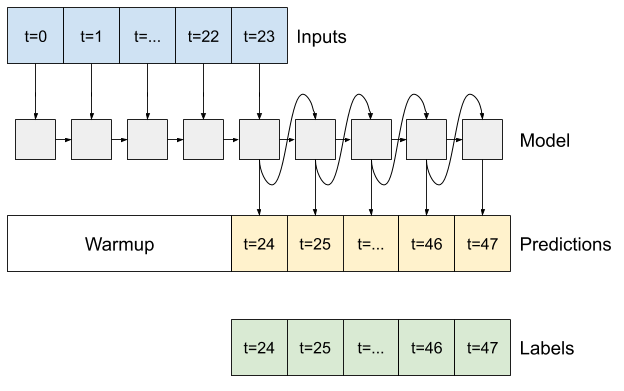

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Colab Notebooks/CamrosTech/multistep_autoregressive.png'))

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

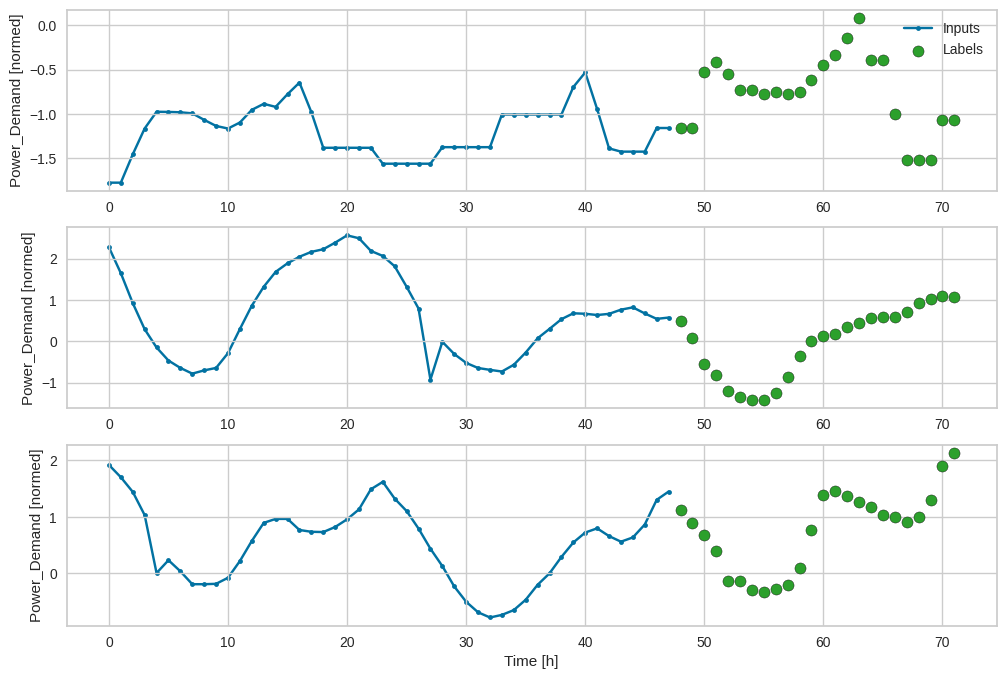

In [ ]:
# autoregressive lstm model
OUT_STEPS = 24
dataset_ar = WindowGenerator(input_width=48,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

dataset_ar.plot()
dataset_ar

In [ ]:
# feedback class
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    return predictions

In [ ]:
feedback_model = FeedBack(units=50, out_steps=OUT_STEPS)

print('Train data ->', dataset_ar.train_df.shape)
print('input shape to LSTM ->', next(iter(dataset_ar.train.take(1)))[0].shape)
print('Number of batches -> ', tf.data.experimental.cardinality(dataset_ar.train).numpy())
print('Output shape (batch, time, features): ', feedback_model(dataset_ar.example[0]).shape)

Train data -> (30693, 14)
input shape to LSTM -> (16, 48, 14)
Number of batches ->  1914
Output shape (batch, time, features):  (16, 24, 14)


Epoch 1/20
1914/1914 [==============================] - 79s 37ms/step - loss: 0.2654 - mean_absolute_error: 0.3446 - mean_absolute_percentage_error: 1961.9822 - val_loss: 0.1926 - val_mean_absolute_error: 0.2868 - val_mean_absolute_percentage_error: 1645.7366
Epoch 2/20
1914/1914 [==============================] - 72s 38ms/step - loss: 0.1863 - mean_absolute_error: 0.2735 - mean_absolute_percentage_error: 1485.5413 - val_loss: 0.1762 - val_mean_absolute_error: 0.2645 - val_mean_absolute_percentage_error: 1342.8210
Epoch 3/20
1914/1914 [==============================] - 76s 40ms/step - loss: 0.1741 - mean_absolute_error: 0.2612 - mean_absolute_percentage_error: 1376.2921 - val_loss: 0.1781 - val_mean_absolute_error: 0.2663 - val_mean_absolute_percentage_error: 1423.3396
Epoch 4/20
1914/1914 [==============================] - 71s 37ms/step - loss: 0.1673 - mean_absolute_error: 0.2548 - mean_absolute_percentage_error: 1360.1964 - val_loss: 0.1741 - val_mean_absolute_error: 0.2603 - val_me

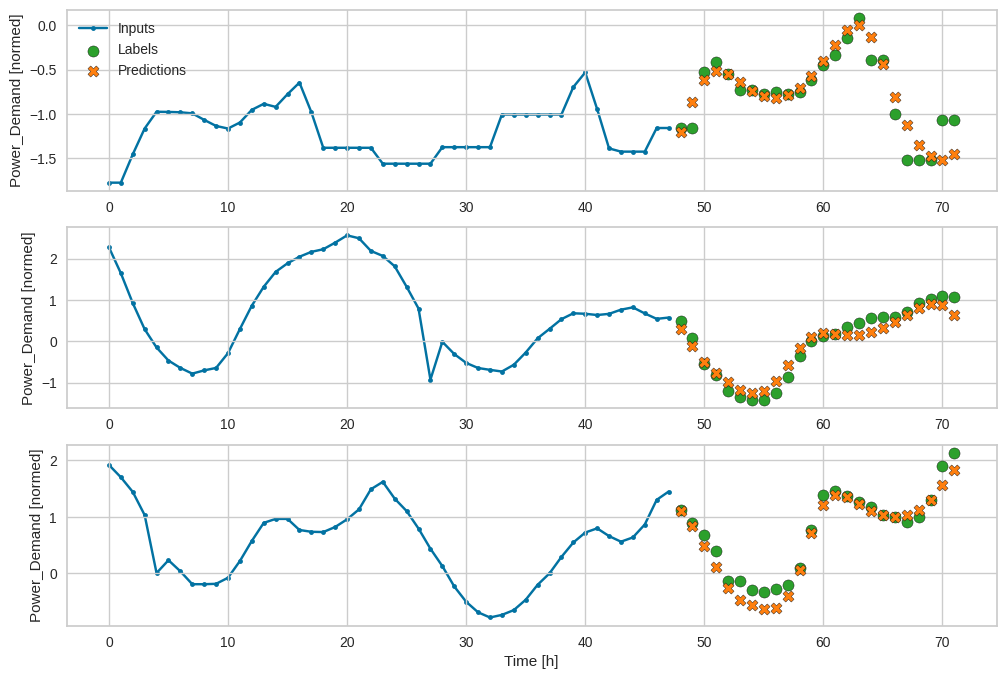

In [ ]:
history = compile_and_fit(feedback_model, dataset_ar)

val_performance['AR LSTM'] = feedback_model.evaluate(dataset_ar.val)
performance['AR LSTM'] = feedback_model.evaluate(dataset_ar.test, verbose=0)
dataset_ar.plot(feedback_model)

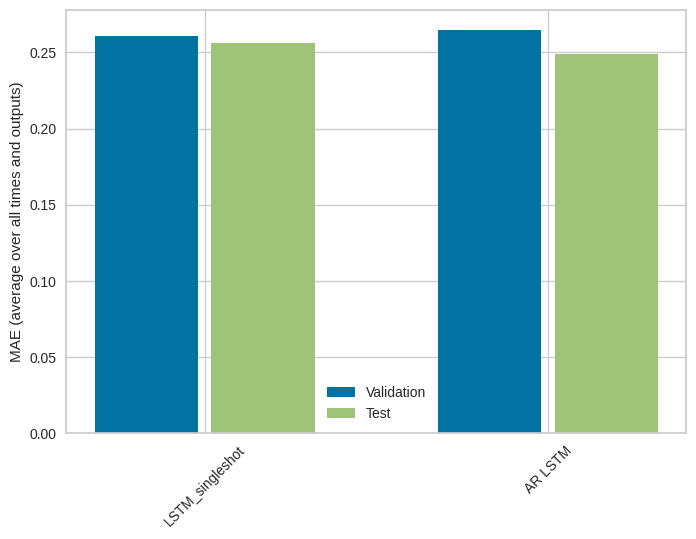

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_singleshot.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
# print('label columns:', window_singleshot.label_columns)
# print('label_columns_indices:', window_singleshot.label_columns_indices)
# print('label_indices:', window_singleshot.label_indices)
# print('label_start:', window_singleshot.label_start)
# print('label_width:', window_singleshot.label_width)
# print('column_indices:', window_singleshot.column_indices)

**Statistical Model**

In [ ]:
demand = df_c['Power_Demand']

<Axes: >

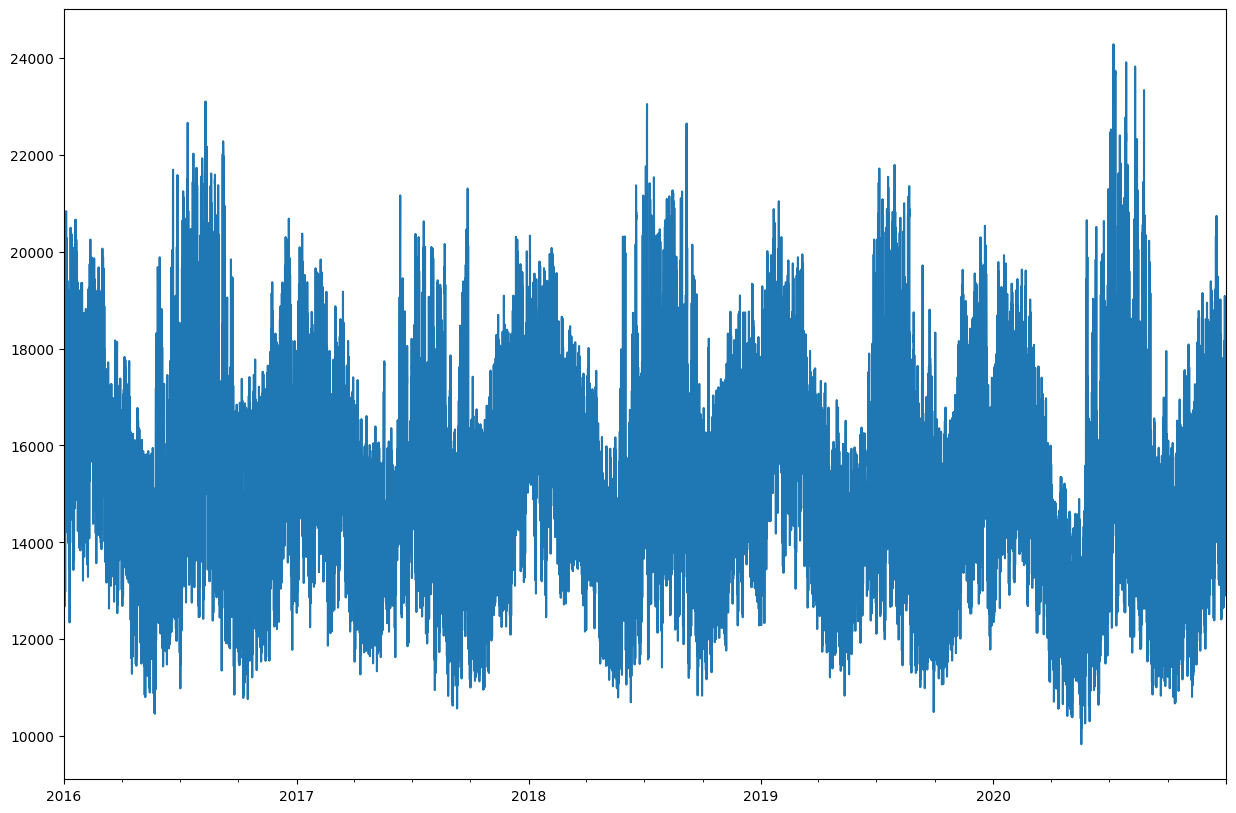

In [ ]:
demand.plot(figsize=(15,10))

array([<Axes: >], dtype=object)

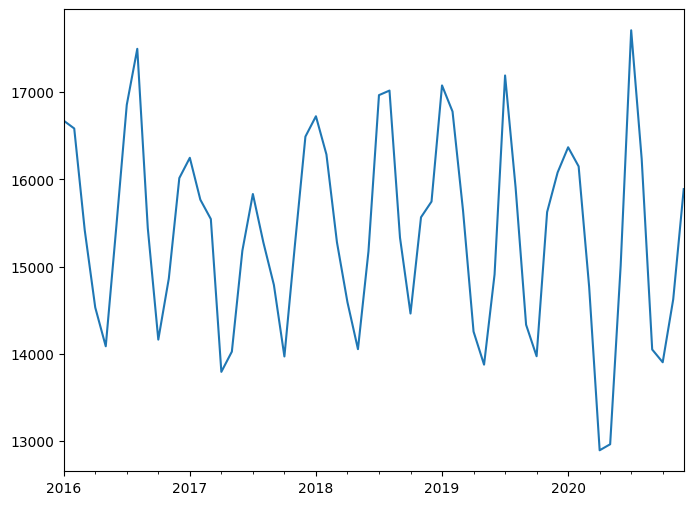

In [ ]:
demand.resample('M').mean().plot(subplots=True)

In [ ]:
from pycaret.time_series import *
s = setup(demand , fold = 3  , fh=24, session_id = 123)

In [ ]:
plot_model(plot = 'decomp_classical')

In [ ]:
plot_model(plot = 'acf')

In [ ]:
plot_model(plot = 'pacf')

In [ ]:
from prophet import Prophet

In [ ]:
df_c['ds'] = df_c.index
demand = df_c[['ds','Power_Demand']].rename(columns={'Power_Demand': 'y'})

In [ ]:
demand.head()

ds      y
2016-01-01 00:00:00 2016-01-01 00:00:00  14023
2016-01-01 01:00:00 2016-01-01 01:00:00  13417
2016-01-01 02:00:00 2016-01-01 02:00:00  12968
2016-01-01 03:00:00 2016-01-01 03:00:00  12968
2016-01-01 04:00:00 2016-01-01 04:00:00  12968

In [ ]:
n = len(demand)
train_demand = demand[0:int(n*0.9)]
test_demand = demand[int(n*0.9):]

In [ ]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
m.fit(train_demand)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp93vk9zbf/ier5o16o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp93vk9zbf/qwkxwkby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7566', 'data', 'file=/tmp/tmp93vk9zbf/ier5o16o.json', 'init=/tmp/tmp93vk9zbf/qwkxwkby.json', 'output', 'file=/tmp/tmp93vk9zbf/prophet_modeldw7csawa/prophet_model-20230601173214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = m.predict(test_demand)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
4380 2020-12-31 19:00:00  18326.324119  12540.793278  23795.708777
4381 2020-12-31 20:00:00  18447.607125  12697.336784  23831.891944
4382 2020-12-31 21:00:00  18195.229206  12327.628920  23737.175347
4383 2020-12-31 22:00:00  17545.092690  11654.339302  22907.728501
4384 2020-12-31 23:00:00  16642.683606  10824.754397  22190.632359

In [ ]:
future = m.make_future_dataframe(periods=100)

In [ ]:
future.shape

(39563, 1)

In [ ]:
forecast_1 = m.predict(future)

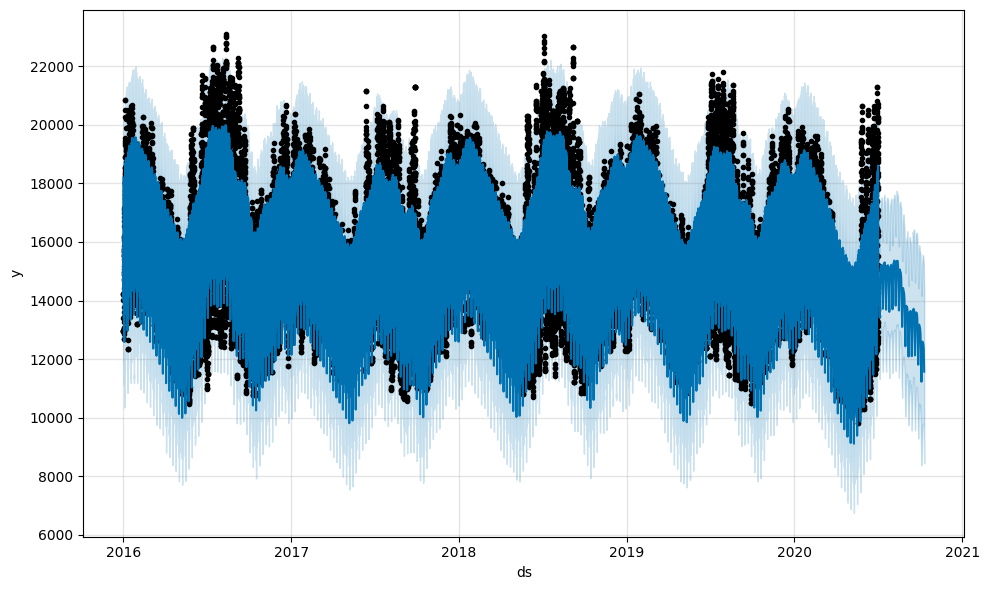

In [ ]:
fig = m.plot(forecast_1)

In [ ]:
from prophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast_1)
py.iplot(fig)

NameError: ignored

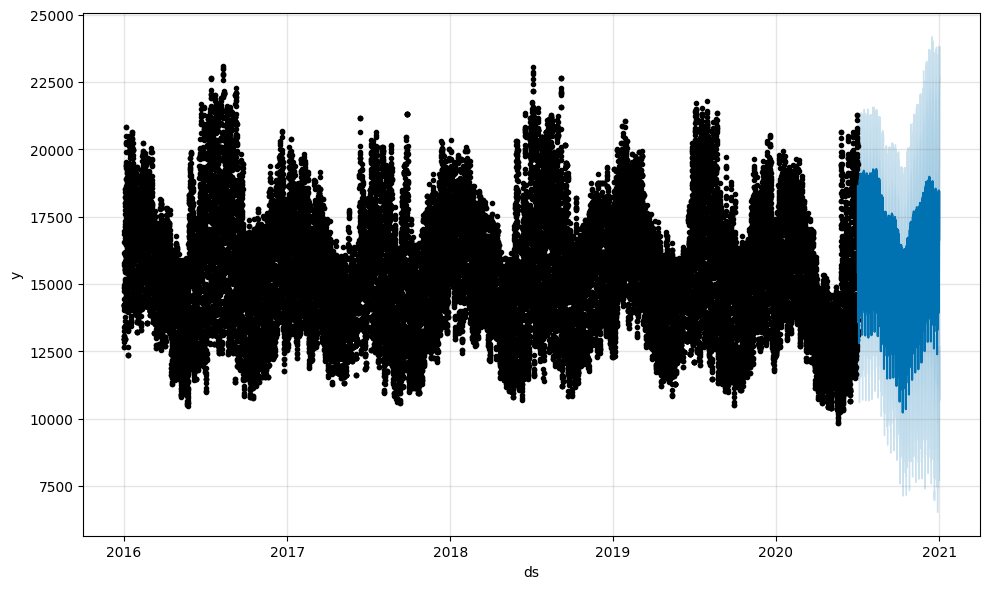

In [ ]:
fig = m.plot(forecast)

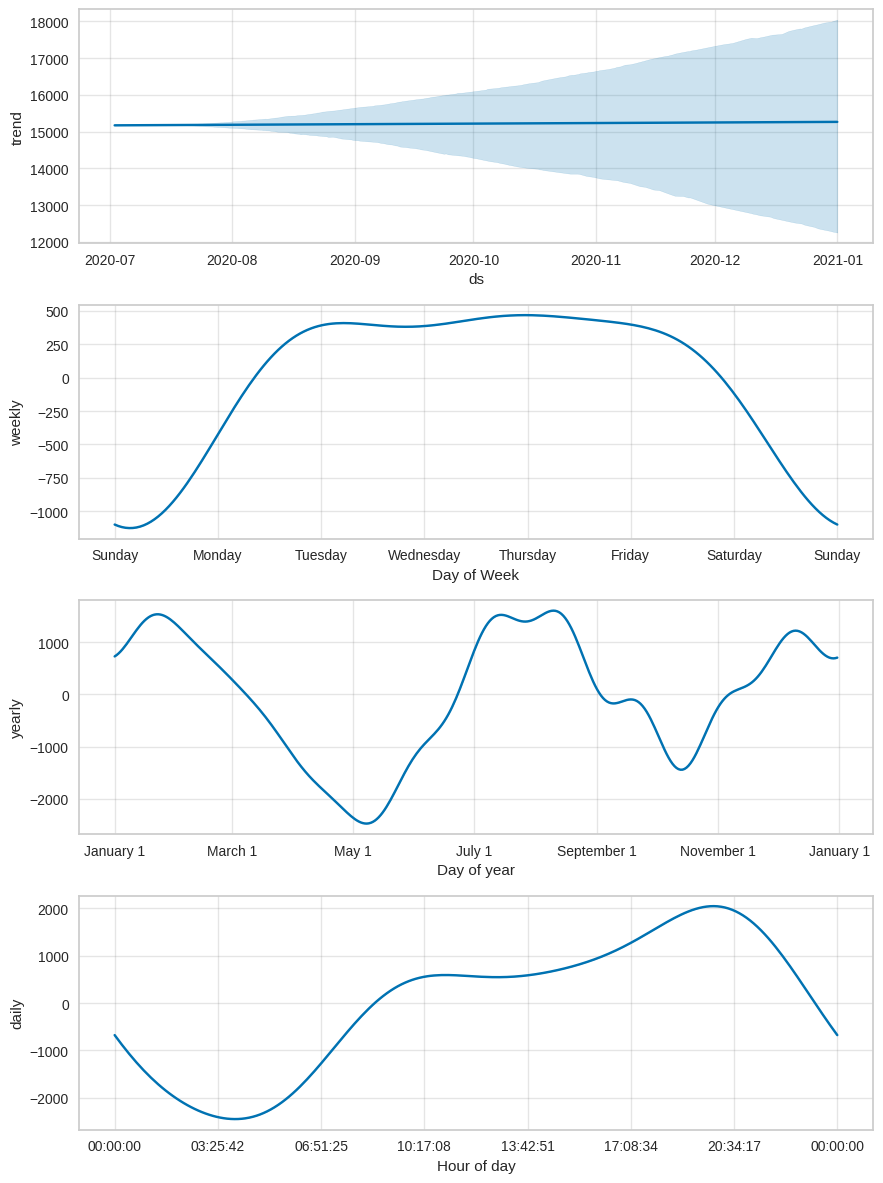

In [ ]:
fig2 = m.plot_components(forecast)

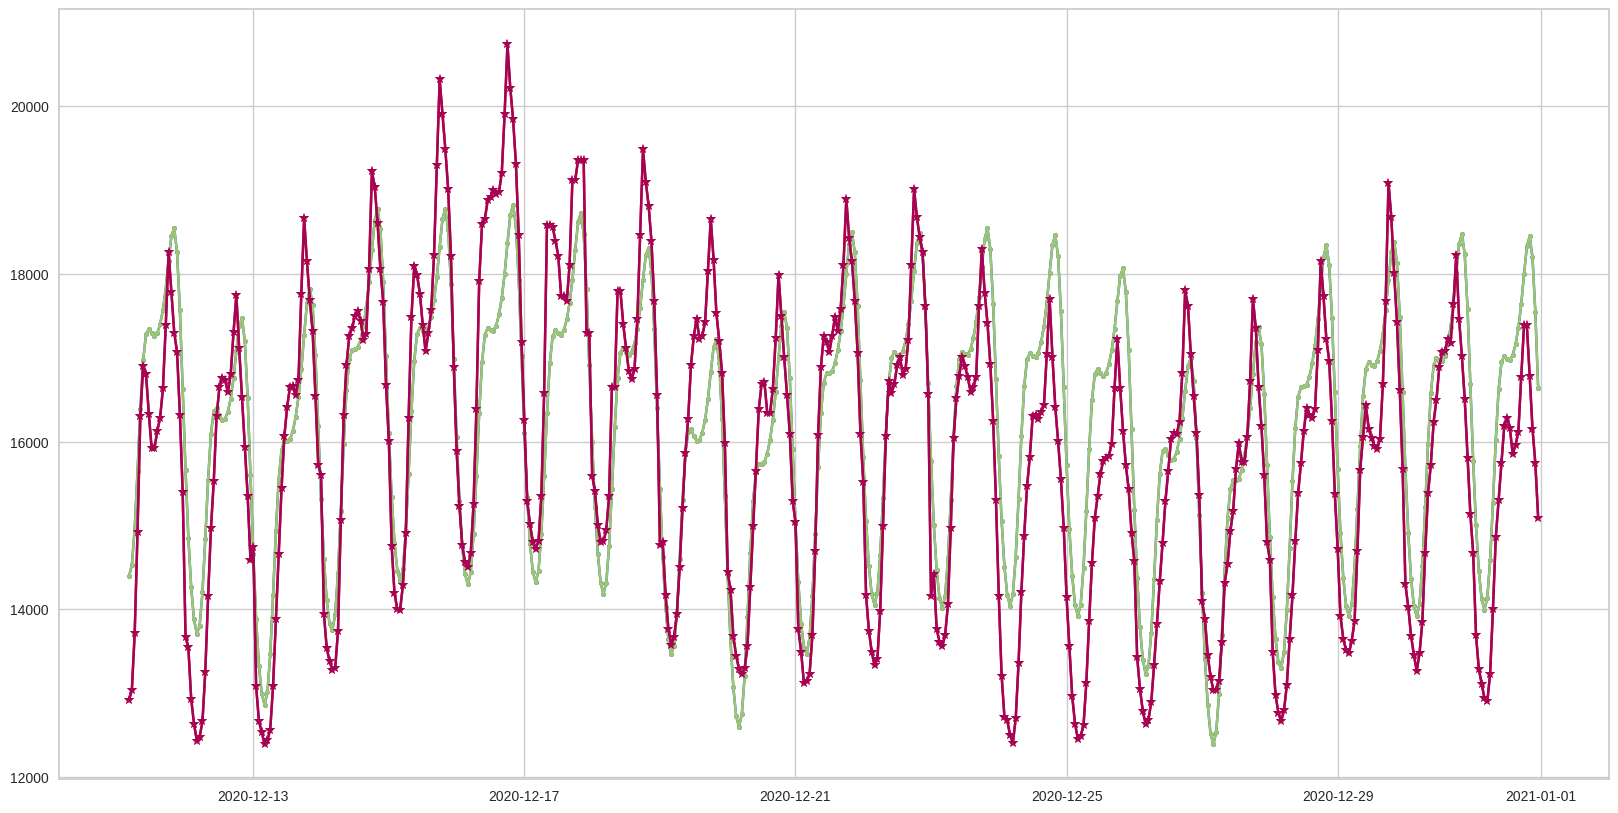

In [ ]:
x = test_demand['ds'].reset_index()
plt.figure(figsize=(20,10))
plt.plot(x.iloc[-500:], forecast['yhat'].iloc[-500:], label='Pred', marker='.')
plt.plot(x.iloc[-500:], test_demand['y'].iloc[-500:], label='True', marker='*')

In [ ]:
mean_absolute_error(y_true=test_demand['y'],
                   y_pred=forecast['yhat'])

1145.3151731694518

In [ ]:
mean_absolute_percentage_error(y_true=test_demand['y'],
                   y_pred=forecast['yhat'])

7.372858931252782